In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

## Loading Dataset

In [2]:
gender = pd.read_csv("../data/gender_anonymized.csv")

#row is the source, column is the target(receiver)
message_adjmatrix = pd.read_csv("../data/slack_direct_matrix_anonymized.csv", index_col=0)
members_c_channel = pd.read_csv("../data/slack_members_count_channel_anonymized.csv")
members_c_group = pd.read_csv("../data/slack_members_count_group_anonymized.csv")
#members_c_group.head()

#message_adjmatrix.head()
#message_adjmatrix.shape

# convert col into int
message_adjmatrix.columns = message_adjmatrix.columns.astype(int)

In [3]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

check_symmetric(message_adjmatrix.to_numpy())
#meaning this should be a directed graph!

False

In [4]:
#this is 900209 (row index = 26) -> 891708 (col name)
#this value can be used for validating successful graph creation!
print("900209 sent 891708:", message_adjmatrix.loc[message_adjmatrix.index[26], 891708], "messages") # 900209 sent 891708 -> 13 
print("891708 sent 900209:", message_adjmatrix.loc[message_adjmatrix.index[5], 900209], "messages") # 891708 sent 900209 ->  26

900209 sent 891708: 13.0 messages
891708 sent 900209: 26.0 messages


## Graph Initialization & Attributes

In [5]:
#https://notebook.community/rtidatascience/connected-nx-tutorial/notebooks/2.%20Creating%20Graphs

# Creating a directed graph! 
GAAdj = nx.from_numpy_matrix(message_adjmatrix.values, create_using=nx.DiGraph())

In [6]:
label_mapping = dict(zip(GAAdj.nodes(), message_adjmatrix.columns))
GAAdj = nx.relabel_nodes(GAAdj, label_mapping)

#checking directed
#nx.is_directed(GAAdj)

print("900209 sent 891708:", GAAdj[900209][891708])
print("891708 sent 900209:", GAAdj[891708][900209])

900209 sent 891708: {'weight': 13.0}
891708 sent 900209: {'weight': 26.0}


In [7]:
#gender.loc[gender['fake_id'] == 719556]['gender'][0]
gender = gender.astype({"fake_id": int})
gender_dict = dict(zip((gender.fake_id), gender.gender))

In [8]:
#set vertex attribute: gender
nx.set_node_attributes(GAAdj, gender_dict, name="gender")

In [9]:
#checking gender of each node
print("gender for 719556:", GAAdj.nodes[719556]["gender"])
print("gender for 230271:", GAAdj.nodes[230271]["gender"])

gender for 719556: M
gender for 230271: F


## Basic Statistic & Measures

In [10]:
print("nodes number: ", GAAdj.number_of_nodes())
print("edges number: ", GAAdj.number_of_edges())

nodes number:  983
edges number:  17377


Text(0.5, 1.0, 'Eigenvector')

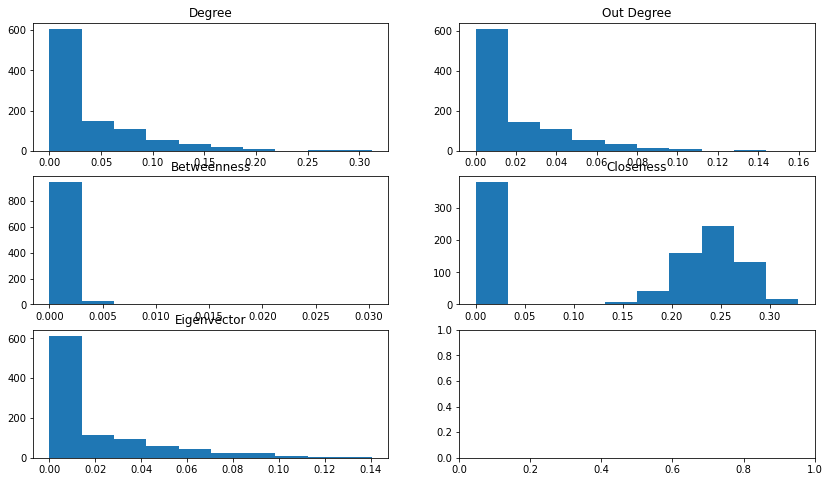

In [11]:
fig, axs = plt.subplots(3, 2, figsize = (14, 8))

axs[0, 0].hist(nx.centrality.degree_centrality(GAAdj).values())
axs[0, 0].set_title('Degree')

axs[0, 1].hist(nx.centrality.out_degree_centrality(GAAdj).values())
axs[0, 1].set_title('Out Degree')

axs[1, 0].hist(nx.centrality.betweenness_centrality(GAAdj).values())
axs[1, 0].set_title('Betweenness')

axs[1, 1].hist(nx.centrality.closeness_centrality(GAAdj).values())
axs[1, 1].set_title('Closeness')

#Eigenvector is not implemente for multi-graph type -> I used DiGraph instead 
#TODO: Is there underlying problem?
axs[2, 0].hist(nx.centrality.eigenvector_centrality(GAAdj).values())
axs[2, 0].set_title('Eigenvector')

In [12]:
#Cluster Average The following is not implemented for directed Graph
#print("Clustering Average:", nx.cluster.average_clustering(GAAdj))

# returns clustering coefficient for each node:
cluster_coeff =nx.clustering(GAAdj)

filtered_vals = [v for _, v in cluster_coeff.items() if v != 0]
average = sum(filtered_vals) / len(filtered_vals)
print("Clustering Average for all nodes with cluster value is:", average, "(does not include nodes with clustering coeffcient of 0)")
print("Clustering Average for all nodes with cluster value is:", sum(filtered_vals) / GAAdj.number_of_nodes())

# if and only if every vertex in the graph is reachable from every other vertex.
print("Graph is strongly connected:", nx.is_strongly_connected(GAAdj))

#if the graph is connected when the direction of the edge between nodes is ignored.
print("Graph is weakly connected:", nx.is_weakly_connected(GAAdj))


#Number of strongly & weakly connected components
#Directed ties or undirected ties => will give you information about the communication silos in the organization 
#Each component can think of an informal group
print("Number of strongly connected components: ", nx.number_strongly_connected_components(GAAdj))
print("Number of weakly connected components: ", nx.number_weakly_connected_components(GAAdj))

#Size of  strongly connected components
largest_strong = max(nx.strongly_connected_components(GAAdj), key=len)
smallest_strong = min(nx.strongly_connected_components(GAAdj), key=len)
print("Size of largest strongly connected components:", len(largest_strong))
print("Size of largest strongly connected components:", len(smallest_strong))

#Size of weakly connected components
largest_weak = max(nx.weakly_connected_components(GAAdj), key=len)
smallest_weak = min(nx.weakly_connected_components(GAAdj), key=len)
print("Size of largest strongly connected components:", len(largest_weak))
print("Size of largest strongly connected components:", len(smallest_weak))

#TODO: histogram of len of connected components => see the average & the distribution 
#str_cc = nx.strongly_connected_components(GAAdj)
#      returns a generator object 
#       print(list(str_cc))

Clustering Average for all nodes with cluster value is: 0.408299605180222 (does not include nodes with clustering coeffcient of 0)
Clustering Average for all nodes with cluster value is: 0.22969448795998246
Graph is strongly connected: False
Graph is weakly connected: False
Number of strongly connected components:  408
Number of weakly connected components:  381
Size of largest strongly connected components: 576
Size of largest strongly connected components: 1
Size of largest strongly connected components: 603
Size of largest strongly connected components: 1


## Number of ties between people of the same sex
Gender Homopholy

In [13]:
node_w_gender = 0
node_no_gender = 0

for node in GAAdj.nodes():
   try:
      if (GAAdj.nodes[node]['gender'] == 'F' or GAAdj.nodes[node]['gender'] == 'M'):
         node_w_gender += 1
   except:
      node_no_gender += 1


print("node with gender attribute:", node_w_gender)
print("node without gender attribute:", node_no_gender)

node with gender attribute: 690
node without gender attribute: 293


In [15]:
samesex_ties = 0
diffsex_ties = 0
label_edges = 0
not_labeled_edges = 0

for u,v in GAAdj.edges():
    #Note: There are some node without gender attribute, we ignore them in this scenari
    try: 
      if (GAAdj.nodes[u]['gender'] == GAAdj.nodes[v]['gender']):
        samesex_ties += 1
      elif (GAAdj.nodes[u]['gender'] != GAAdj.nodes[v]['gender']):
        diffsex_ties += 1

      label_edges += 1
    except:
       #if one of node of the edge does not have gender attribute
       not_labeled_edges += 1
       pass

print("Number of Ties between Same Sex: ", samesex_ties)
print("Number of Ties between Different Sex:", diffsex_ties)
print("Number of Ties without Gender Attribute: ", not_labeled_edges)
    
#print((both_labeled_edges + not_labeled_edges) == GAAdj.number_of_edges())
print("Percentage of Reaching out to Same Gender, excluding non-gendered nodes:", samesex_ties / label_edges)
print("Percentage of Reaching out to Different Gender, excluding non-gendered nodes:", diffsex_ties / label_edges)

Number of Ties between Same Sex:  7192
Number of Ties between Different Sex: 5562
Number of Ties without Gender Attribute:  4623
Percentage of Reaching out to Same Gender, excluding non-gendered nodes: 0.5639015210914223
Percentage of Reaching out to Different Gender, excluding non-gendered nodes: 0.4360984789085777


In [ ]:
# Homopholy 

#TODO: Json
# Number of ties between people working in the same department/team/channel/group  

# Number of ties between different combinations of leaders(1) and non-leaders(0) #the managerial data 

# Total messages sent: sum of (messages sent from sender to receiver)/100 for all Advice ties 


#Statistical Test:
#Exponential Random Graph Models (ERGMs)

#Regression: 
# assumption, node attributes are independent 
# ties in the network are interdependent to each other;      
  #ie if i have tie with Jasmine, I also have tie with Carli => it's more likely for Jasmine & Carli also has tie (friends' friend) = closure
#ties in the network are not independent of each other  

#that's why we use Exponential Random Graph Models (ERGMs)
#number of tri to compare, if possiblity of ties are higher or lower than the random chance. 